# Examen práctico 
## Parcial 1 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [42]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def vibariado(df, y):
    target = y.name
    num_vars = len(df.keys().drop(target))
    num_rows = (num_vars + 1) // 2 
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for idx, i in enumerate(df.keys().drop(target)):
        X = df[[i]]
        model = linear_model.LinearRegression().fit(X, y)
        
        q = len(X.iloc[:, 0].unique()) if len(X.iloc[:, 0].unique()) < 5 else 10
        df[i + "_bin"] = pd.qcut(df[i], q=q, labels=False, duplicates="drop") + 1
        grouped = df.groupby(i + "_bin").mean()
        
        ax = axes[idx]
        ax.plot(grouped[i].values, grouped[target].values, color=colors[0], marker='o')
        ax.set_xlabel(f"{i} bins")
        ax.set_ylabel(target)
        ax.set_title(f"Análisis bivariado entre {i} y {target}")
        ax.grid()
        
        df.drop(columns=[i + "_bin"], inplace=True)
    
    plt.tight_layout()
    plt.show()

def comparacion(modelos, y):
     plt.figure(figsize=(10, 5))

     for i, modelo in enumerate(modelos):
          col_pred = f'predicciones_{modelo}'

          df_calibracion = pd.DataFrame({
               'predicciones': globals()[col_pred],
               'y': y
          })

          df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=10, labels=False)+1
          grouped = df_calibracion.groupby('bins').mean()
          plt.plot(grouped['predicciones'].values, grouped['y'].values, marker='o', color=colors[i], label=modelos[i])

     plt.plot(grouped['predicciones'].values, grouped['predicciones'].values, color=colors[-1], linestyle="--", label="Real", zorder=100)
     plt.xlabel("Valores predichos")
     plt.ylabel("Valores reales")
     plt.title("Comparación de modelos")
     plt.grid()
     plt.legend()
     plt.show()

def graficas_KNN(resultados, nn_opt):
     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

     axes[0].plot(resultados.nn, resultados.r2, label='real', color=colors[0], marker='o')
     axes[0].grid()
     axes[0].set_title("$R^2$ Real")
     axes[0].set_xlabel("Nearest Neighbors")
     axes[0].set_ylabel("$R^2$")

     axes[1].plot(resultados.nn, resultados.r2_train, label='train', color=colors[1], marker='o')
     axes[1].grid()
     axes[1].set_title("$R^2$ Train")
     axes[1].set_xlabel("Nearest Neighbors")
     axes[1].set_ylabel("$R^2$")

     plt.show()

     plt.figure(figsize=(15, 5))
     plt.plot(resultados.nn, resultados.r2, label='Real', color=colors[0], marker='o')
     plt.plot(resultados.nn, resultados.r2_train, label='Train', color=colors[1], marker='o')
     plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color=colors[2], s=50, zorder=3)
     plt.text(nn_opt, max(resultados.r2)-0.05, f"Máximo $R^2$", va='bottom')
     plt.grid()
     plt.legend()
     plt.title("$R^2$ Real vs Train")
     plt.xlabel("Nearest Neighbors")
     plt.ylabel("$R^2$")
     plt.show()

# Data

In [43]:
data = pd.read_csv("Data/Boston.csv")
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Explicación variables Dataset

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

## Limpieza de datos

In [44]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Variable dependiente

In [45]:
target = 'medv'
y = data[target]

# Análisis Dataset

## Correlación

<Axes: >

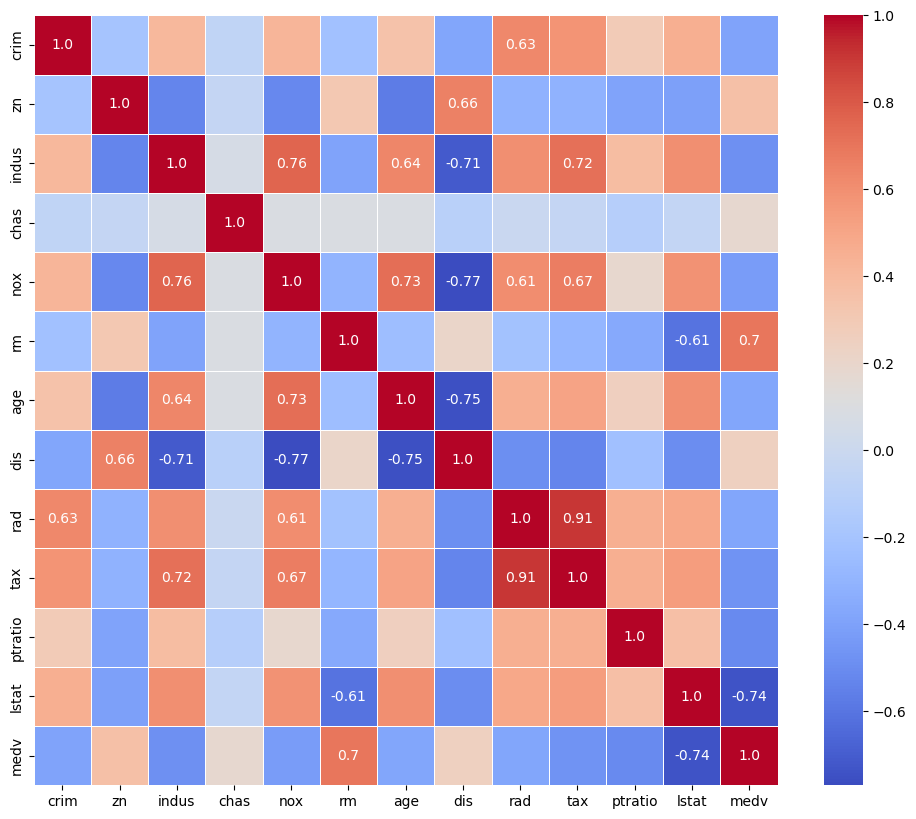

In [46]:
corr_matrix = data.corr().round(2)
mask = np.abs(corr_matrix) > 0.6
annot = np.where(mask, corr_matrix.astype(str), "")

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=annot, cmap="coolwarm", fmt="", linewidths=0.5)

In [47]:
pd.DataFrame(data.corr()[target]).sort_values(by=target, ascending=False).drop(index=target)

,medv
rm,0.695360
zn,0.360445
dis,0.249929
chas,0.175260
age,-0.376955
rad,-0.381626
crim,-0.388305
nox,-0.427321
tax,-0.468536
indus,-0.483725


## Análisis vibariado

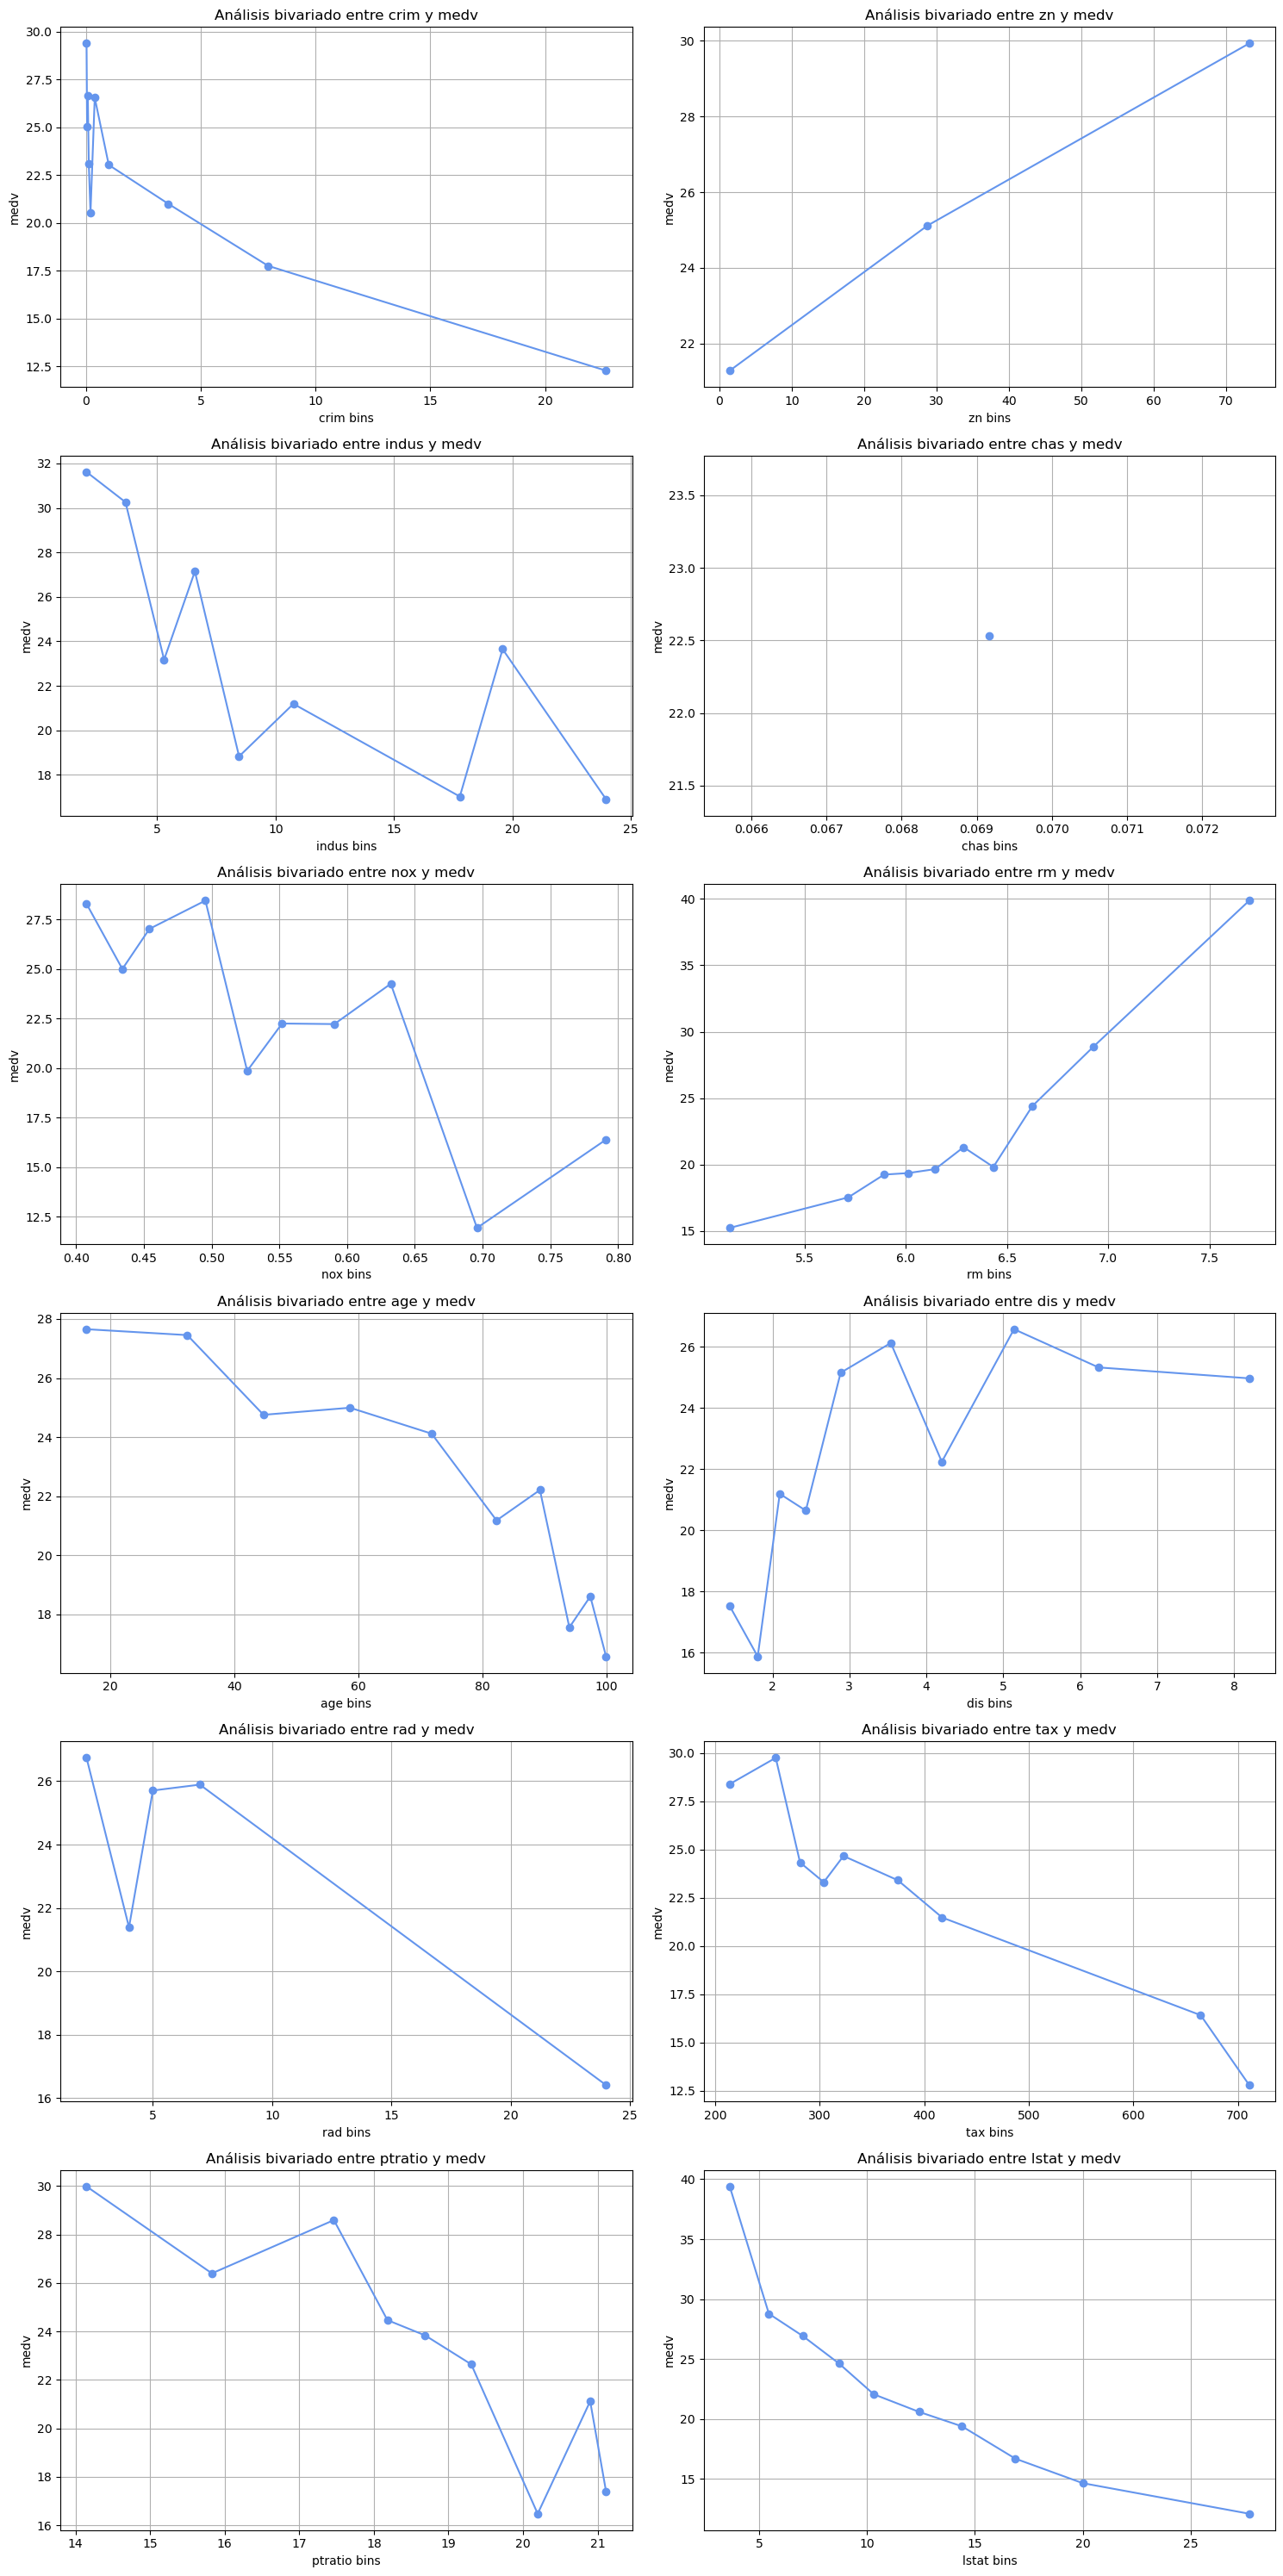

In [48]:
vibariado(data, y)

# Feature engineering

In [49]:
data

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


## Dummies

In [50]:
data = pd.get_dummies(data, columns=['rad'])

## Nuevas Variables
- Relación entre impuestos y accesibilidad a carreteras

In [11]:
for col in data.iloc[:,12:].columns:  
    data[f'tax_{col}'] = data['tax'] * data[col]

data['nox_indus'] = data['nox'] / (data['indus'] + 1)
data['age_nox'] = data['age'] / (data['nox'] + 1)
data['dis_zn'] = data['dis'] / (data['zn'] + 1)
data['dis_indus'] = data['dis'] / (data['indus'] + 1)
data['dis_nox'] = data['dis'] / (data['nox'] + 1)
data['dis_age'] = data['dis'] / (data['age'] + 1)
data['tax_indus'] = data['tax'] / (data['indus'] + 1)
data['tax_nox'] = data['tax'] / (data['nox'] + 1)
#data[''] = data[''] / data['']

'''new_features_df = pd.DataFrame()
new_features_df['crim_indus'] = df['crim'] / (1+df['indus']) # +1 para evitar divisiones entre cero
new_features_df['crim_lstat'] = df['crim'] / (1+df['lstat'])
new_features_df['rm_lstat'] = df['rm'] / (1+df['lstat'])
new_features_df['nox_indus'] = df['nox'] / (1+df['indus'])
new_features_df['nox_dis'] = df['nox'] / (1+df['dis'])
new_features_df['age_lstat'] = df['age'] / (1+df['lstat'])
new_features_df['tax_rm'] = df['tax'] / (1+df['rm'])
new_features_df['tax_lstat'] = df['tax'] / (1+df['lstat'])
new_features_df['ptratio_rm'] = df['ptratio'] / (1+df['rm'])
new_features_df['ptratio_nox'] = df['ptratio'] / (1+df['nox'])
new_features_df['ptratio_dis'] = df['ptratio'] / (1+df['dis'])
new_features_df['nox_age'] = df['nox'] / (1+df['age'])
new_features_df['dis_indus'] = df['dis'] / (1+df['indus'])
new_features_df['tax_indus'] = df['tax'] / (1+df['indus'])'''

## Transformaciones

- Logaritmo de la tasa de crimen per capita por ciudad
- Logaritmo de la concentración de óxido nitrico
- Cuadrado de número de cuartos promedio por vivienda
- Raíz de la distancia ponderada de 5 centros de empleo en Boston
- Logaritmo del valor total de la propiedad por la tasa de impuestos por $10,000

In [12]:
data['log_crim'] = np.log(data['crim'])
data['log_nox'] = np.log(data['nox'])
data['rm_2'] = data['rm'] ** 2
data['sqrt_dis'] = np.sqrt(data['dis'])
data['log_tax'] = np.log(data['tax'])

used_variables.extend(['crim', 'rm'])

In [13]:
data = data.drop(columns=used_variables)

# Significancia de variables

In [ ]:
controls = data.keys().drop(target)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

In [ ]:
controls = controls.drop('indus')
data.drop('indus', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

In [ ]:
controls = controls.drop('tax')
data.drop('tax', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

In [ ]:
controls = controls.drop('log_crim')
data.drop('log_crim', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

In [ ]:
controls = controls.drop('age')
data.drop('age', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

In [ ]:
controls = controls.drop('log_nox')
data.drop('log_nox', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

In [ ]:
controls = controls.drop('zn')
data.drop('zn', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

# Preparación de datos

## Cross validation

In [14]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaler

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresión lineal múltiple

## Modelo normal

In [16]:
model = linear_model.LinearRegression().fit(X_train_scaled, y_train)
predicciones_RLM = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.7579
MSE: 18.0397

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,chas,1.009365
1,ptratio,-1.589946
2,lstat,-4.016154
3,rad_1,2.356648
4,rad_2,2.626943
5,rad_3,2.736662
6,rad_4,4.567644
7,rad_5,3.066986
8,rad_6,1.050450
9,rad_7,1.141155


### Calibración

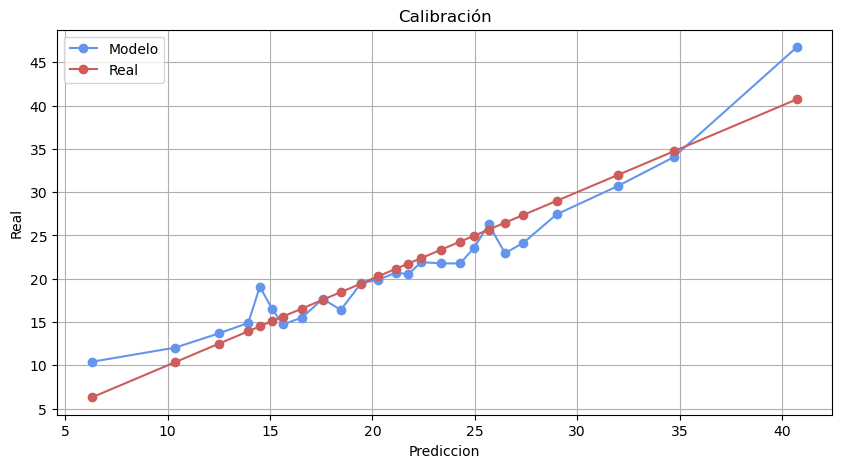

In [17]:
calibracion(predicciones_RLM, y_test, 25)

## Regularización Ridge

In [18]:
model = linear_model.Ridge().fit(X_train_scaled, y_train)
predicciones_RLM_ridge = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.7577
MSE: 18.0536

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,chas,0.937431
1,ptratio,-1.709979
2,lstat,-4.102052
3,rad_1,0.338243
4,rad_2,1.038320
5,rad_3,0.044653
6,rad_4,0.920073
7,rad_5,0.107391
8,rad_6,-0.827237
9,rad_7,-0.665893


### Calibración

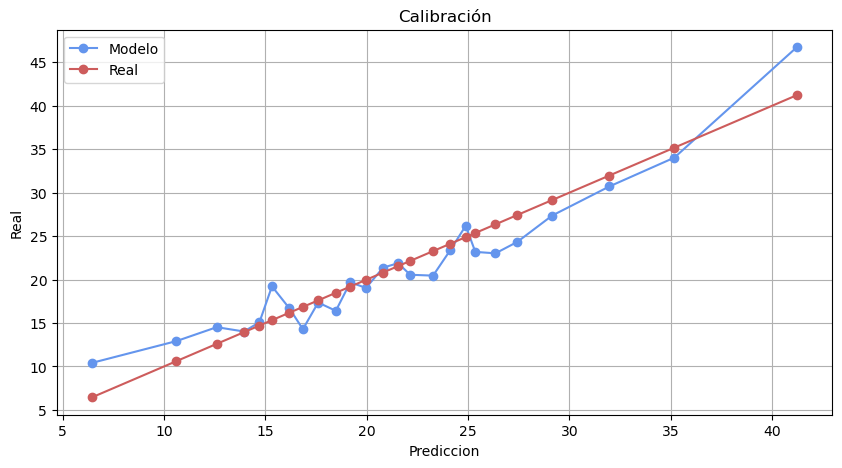

In [19]:
calibracion(predicciones_RLM_ridge, y_test, 25)

## Regularización Lasso

In [20]:
model = linear_model.Lasso().fit(X_train_scaled, y_train)
predicciones_RLM_lasso = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.6630
MSE: 25.1073

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,chas,0.183216
1,ptratio,-1.176012
2,lstat,-3.737086
3,rad_1,-0.000000
4,rad_2,0.000000
5,rad_3,0.000000
6,rad_4,-0.000000
7,rad_5,0.000000
8,rad_6,-0.000000
9,rad_7,0.000000


### Calibración

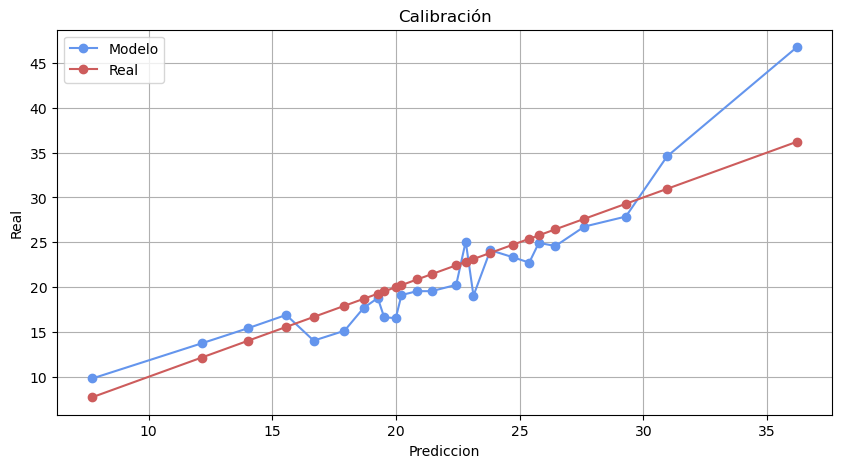

In [21]:
calibracion(predicciones_RLM_lasso, y_test, 25)

## Comparación modelos

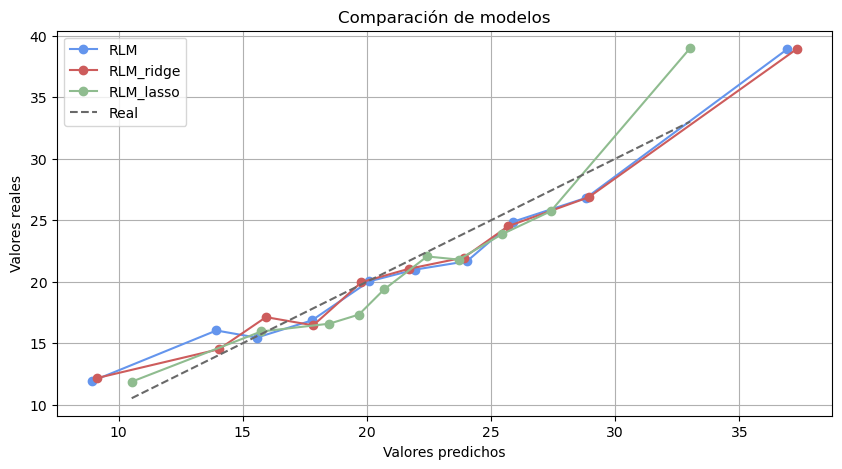

In [22]:
modelos = ['RLM', 'RLM_ridge', 'RLM_lasso']

comparacion(modelos, y_test)

# Regresión polinomial

## Grado 2

In [23]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [24]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly2 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2)
print(f"MSE: {mse:,.4f}")

R² Score: -5,111,681,473,840,189,276,160.0000
MSE: 380,887,210,172,749,359,087,616.0000


#### Calibración

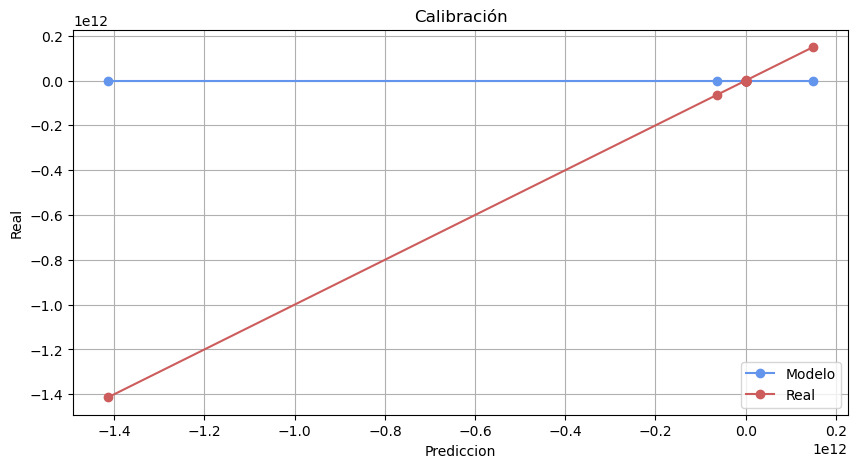

In [25]:
calibracion(predicciones_poly2, y_test, 25)

### Regularización Ridge

In [26]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly2_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7392
MSE: 19.4361


#### Calibración

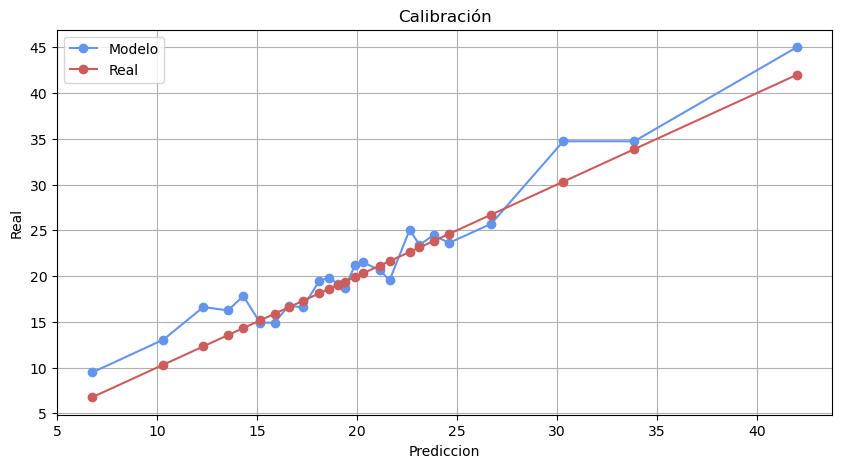

In [27]:
calibracion(predicciones_poly2_ridge, y_test, 25)

### Regularización Lasso

In [28]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly2_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7543
MSE: 18.3101


#### Calibración

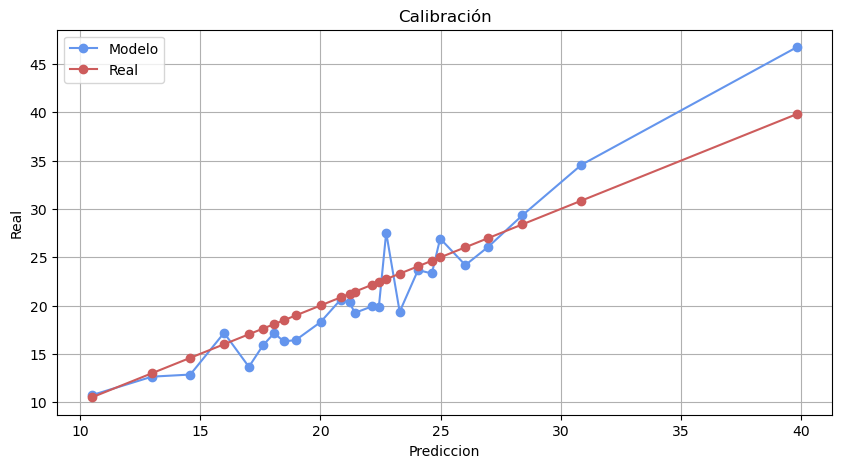

In [29]:
calibracion(predicciones_poly2_lasso, y_test, 25)

### Comparación modelos

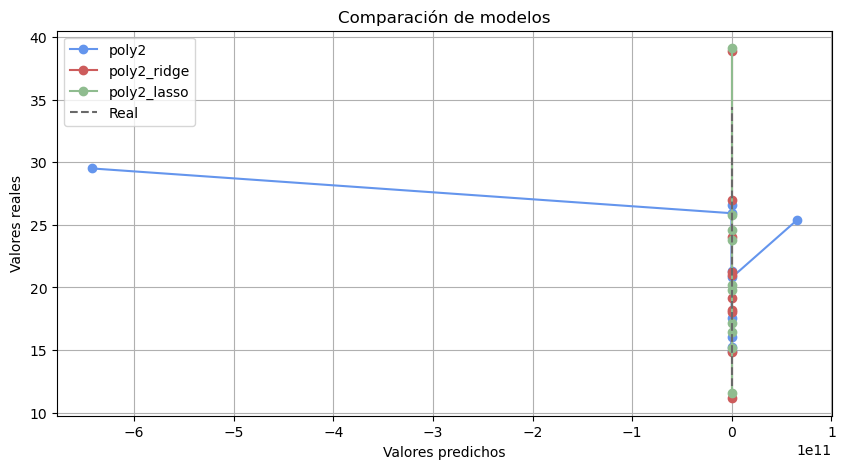

In [30]:
modelos = ['poly2', 'poly2_ridge', 'poly2_lasso']

comparacion(modelos, y_test)

## Grado 3

In [31]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [32]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly3 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3)
print(f"MSE: {mse:,.4f}")

R² Score: -4,154.5854
MSE: 309,645.5294


#### Calibración

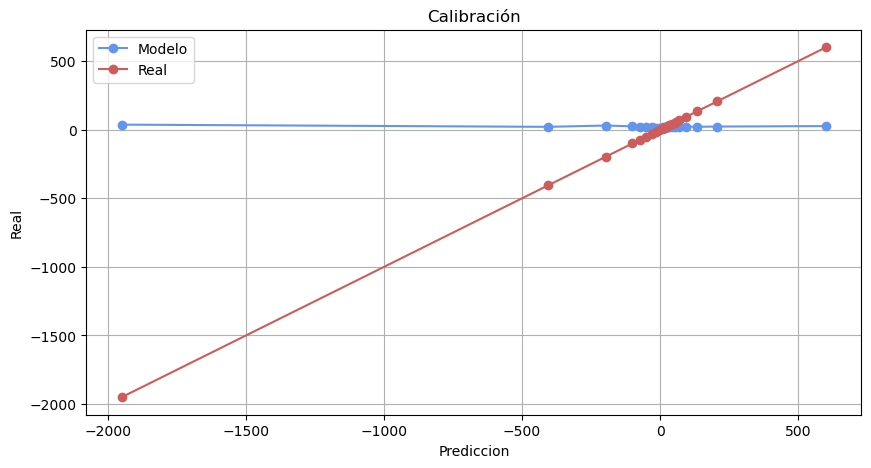

In [33]:
calibracion(predicciones_poly3, y_test, 25)

### Regularización Ridge

In [34]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly3_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: -1.0447
MSE: 152.3578


#### Calibración

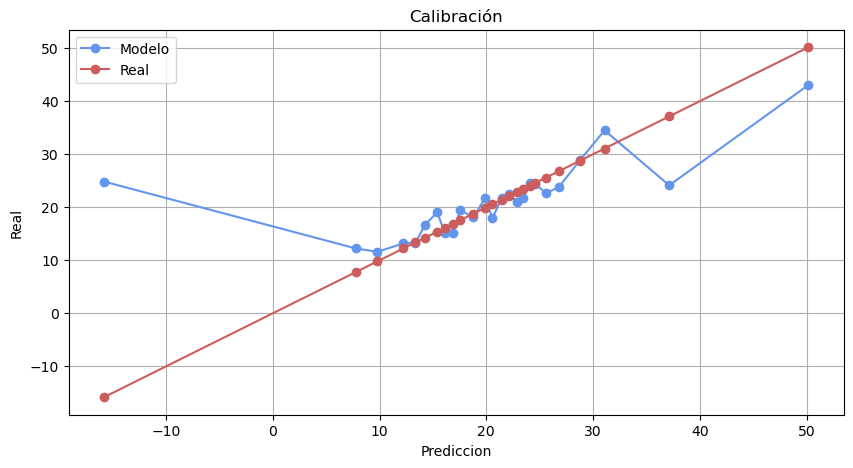

In [35]:
calibracion(predicciones_poly3_ridge, y_test, 25)

### Regularización Lasso

In [36]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly3_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.6858
MSE: 23.4102


#### Calibración

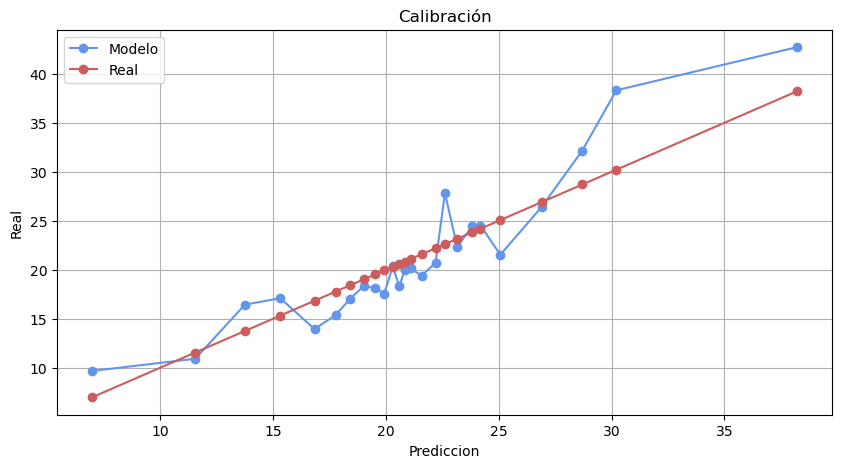

In [37]:
calibracion(predicciones_poly3_lasso, y_test, 25)

### Comparación modelos

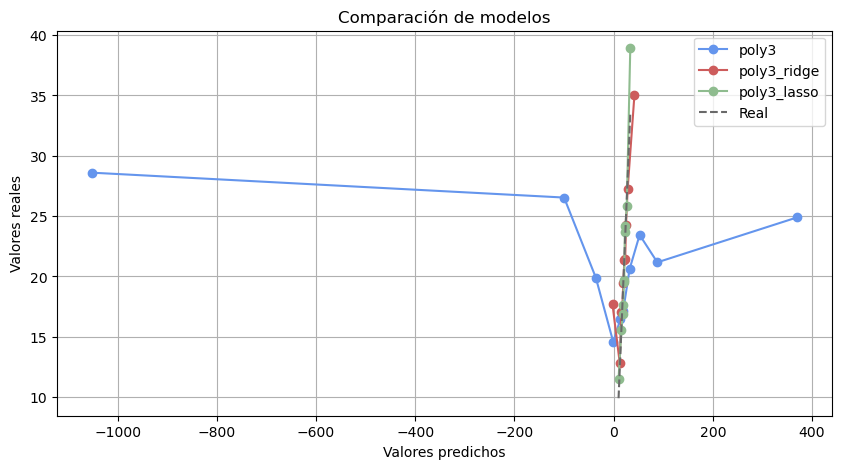

In [38]:
modelos = ['poly3', 'poly3_ridge', 'poly3_lasso']

comparacion(modelos, y_test)

# KNN

## Aproximación gráfica

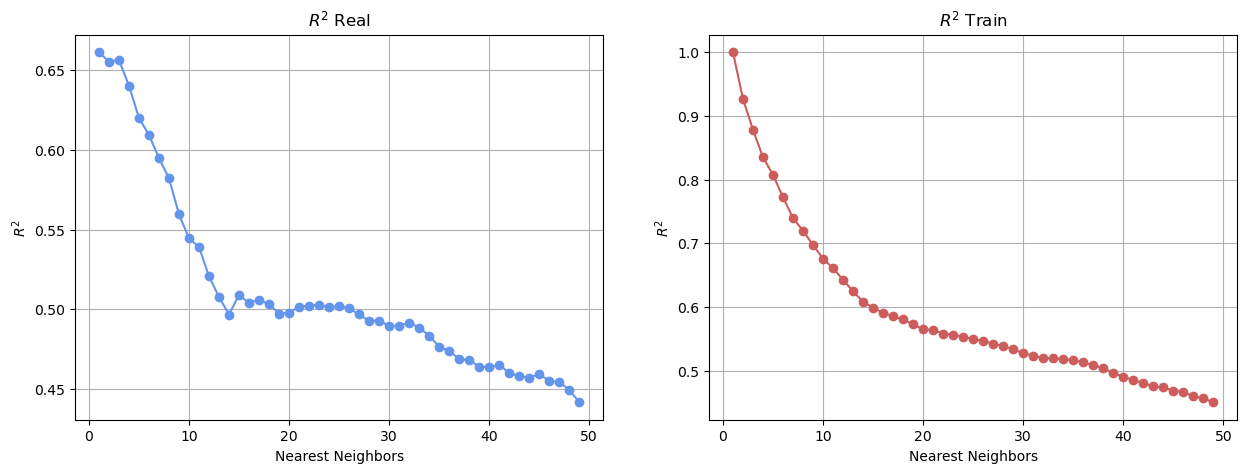

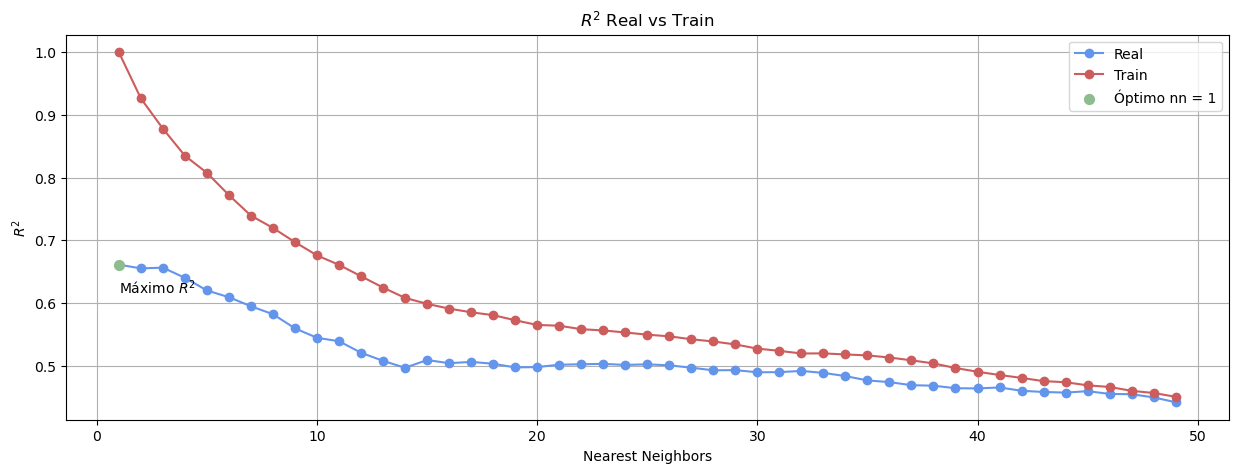

In [39]:
nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)

    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)

    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})

nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]

graficas_KNN(resultados, nn_opt)

## Prueba y error

In [40]:
model = KNeighborsRegressor(n_neighbors=nn_opt-1 if nn_opt > 1 else nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_minus = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt+1).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_plus = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R2 con {nn_opt-1 if nn_opt > 1 else nn_opt} neighbors: {nn_opt_nbr_minus:.4f} \nR2 con {nn_opt} neighbors: {nn_opt_nbr:.4f} \nR2 con {nn_opt+1} neighbors: {nn_opt_nbr_plus:.4f}")

R2 con 1 neighbors: 0.6611 
R2 con 1 neighbors: 0.6611 
R2 con 2 neighbors: 0.6552


# Conclusiones generales